## import Libraries and Prepare Data

In [1]:
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import os
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

imsize = 512 if torch.cuda.is_available() else 128
print(f"Image size: {imsize}")

transform = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor(),
])

def load_image(image_path, size=None):
    image = Image.open(image_path)
    if size is not None:
        image = transforms.Resize(size)(image)
    image = transform(image).unsqueeze(0)
    return image.to(device)

def get_image_size(image):
    return image.shape[2], image.shape[3]

def imshow(tensor, title=None):
    image = tensor.cpu().clone().detach().squeeze(0)
    image = transforms.ToPILImage()(image)

    # Resize the image to match the smallest dimension (width or height)
    min_size = min(image.size)
    transform_resize = transforms.Resize(min_size)
    image = transform_resize(image)

    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.show()

class StyleTransfer(nn.Module):
    def __init__(self, cnn, normalization_mean, normalization_std,
                 content_image, style_image, content_layers=None, style_layers=None):
        super(StyleTransfer, self).__init__()
        self.cnn = copy.deepcopy(cnn)
        self.normalization = Normalization(normalization_mean, normalization_std).to(device)

        if content_layers is None:
            content_layers = ['conv_4']
        if style_layers is None:
            style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

        self.content_layers = content_layers
        self.style_layers = style_layers

        self.model, self.content_losses, self.style_losses = self.get_model_and_losses(content_image, style_image)

    def get_model_and_losses(self, content_image, style_image):
        content_losses = []
        style_losses = []
        model = nn.Sequential(self.normalization)
        i = 0

        for layer in self.cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = f'conv_{i}'
            elif isinstance(layer, nn.ReLU):
                name = f'relu_{i}'
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = f'pool_{i}'
            elif isinstance(layer, nn.BatchNorm2d):
                name = f'bn_{i}'
            else:
                raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

            model.add_module(name, layer)

            if name in self.content_layers:
                target = model(content_image).detach()
                content_loss = ContentLoss(target)
                model.add_module(f"content_loss_{i}", content_loss)
                content_losses.append(content_loss)

            if name in self.style_layers:
                target_feature = model(style_image).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module(f"style_loss_{i}", style_loss)
                style_losses.append(style_loss)

        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, content_losses, style_losses

    def gram_matrix(self, input):
        a, b, c, d = input.size()
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t())
        return G.div(a * b * c * d)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)

    def forward(self, img):
        return (img - self.mean) / self.std

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = StyleTransfer.gram_matrix(self, target_feature).detach()

    def forward(self, input):
        G = StyleTransfer.gram_matrix(self, input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(style_transfer, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
     
    optimizer = get_input_optimizer(input_img)
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            style_transfer.model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_transfer.style_losses:
                style_score += sl.loss
            for cl in style_transfer.content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            sl=style_score
            cl=content_score
            if run[0] % 50 == 0:
                print(f"run {run[0]}:")
                print(f'Style Loss : {style_score.item():4f} Content Loss: {content_score.item():4f}')
                print()

            return loss

        optimizer.step(closure)
    input_img.data.clamp_(0, 1)
    return input_img

cnn = models.vgg19(pretrained=True).features.to(device).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


working_dir = "/Users/pushpendrammishra/Desktop/ neural transfer style"
content_dir = os.path.join(working_dir, "content")
style_dir = os.path.join(working_dir, "style")
output_dir = os.path.join(working_dir, "output")
os.makedirs(output_dir, exist_ok=True)

content_images = os.listdir(content_dir)
style_images = os.listdir(style_dir)

for content_image_name in content_images:
    for style_image_name in style_images:
        content_image_path = os.path.join(content_dir, content_image_name)
        style_image_path = os.path.join(style_dir, style_image_name)
        output_image_name = f"{os.path.splitext(content_image_name)[0]}_{os.path.splitext(style_image_name)[0]}.jpg"
        print("Building model for content image ",os.path.splitext(content_image_name)[0]," Vs style image ",os.path.splitext(style_image_name)[0])
        content_image = load_image(content_image_path)
        style_image = load_image(style_image_path, get_image_size(content_image))

        style_transfer = StyleTransfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_image, style_image)

        input_image = content_image.clone()

        output_image = run_style_transfer(style_transfer, input_image)

       
        output_image_path = os.path.join(output_dir, output_image_name)
        output_image_pil = transforms.ToPILImage()(output_image.squeeze(0).cpu())
        output_image_pil.save(output_image_path)

        print(f"Saved stylized image: {output_image_path}")

        
       


Using device: cpu
Image size: 128
Building model for content image  golden_gate  Vs style image  mosaic
run 50:
Style Loss : 254.559265 Content Loss: 43.086601

run 100:
Style Loss : 89.223396 Content Loss: 46.277252

run 150:
Style Loss : 50.947437 Content Loss: 46.920052

run 200:
Style Loss : 35.584515 Content Loss: 46.610123

run 250:
Style Loss : 28.483049 Content Loss: 45.889324

run 300:
Style Loss : 22.889393 Content Loss: 45.111115

Saved stylized image: /Users/pushpendrammishra/Desktop/ neural transfer style/output/golden_gate_mosaic.jpg
Building model for content image  golden_gate  Vs style image  wave_crop
run 50:
Style Loss : 88.712364 Content Loss: 28.112951

run 100:
Style Loss : 33.631779 Content Loss: 28.222906

run 150:
Style Loss : 17.856569 Content Loss: 27.356232

run 200:
Style Loss : 11.950424 Content Loss: 26.306215

run 250:
Style Loss : 9.232784 Content Loss: 25.365398

run 300:
Style Loss : 7.717947 Content Loss: 24.537064

Saved stylized image: /Users/pushp

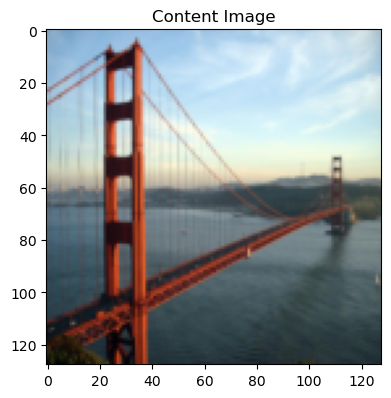

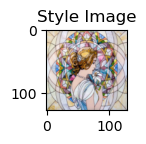

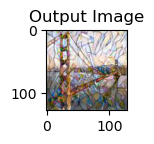

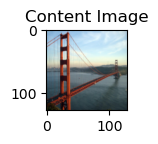

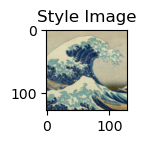

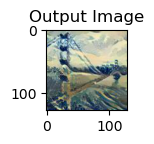

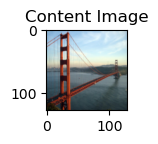

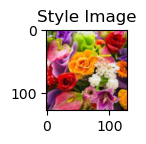

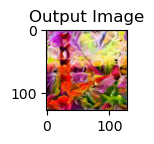

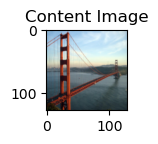

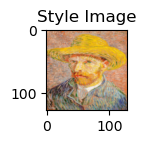

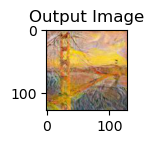

<Figure size 640x480 with 0 Axes>

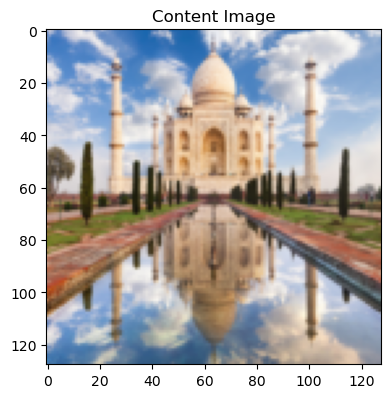

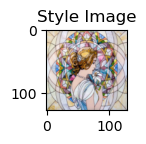

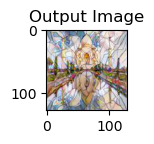

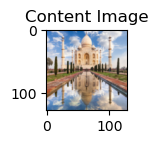

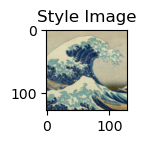

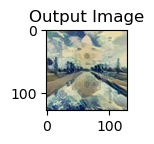

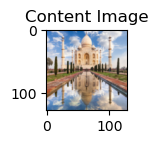

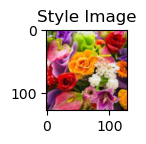

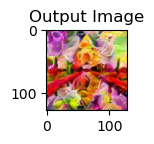

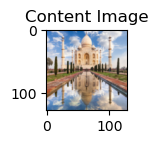

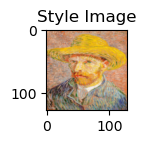

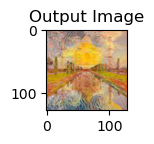

<Figure size 640x480 with 0 Axes>

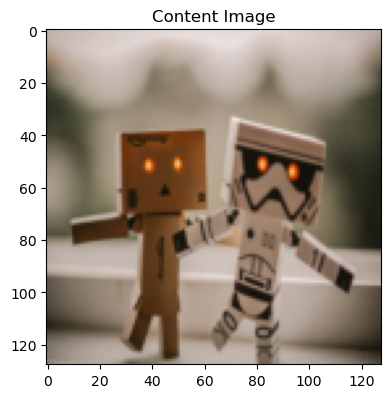

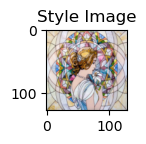

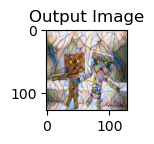

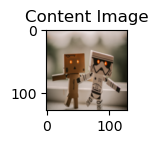

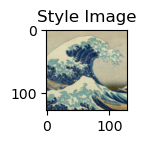

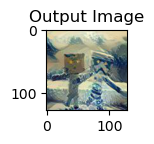

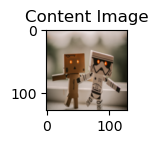

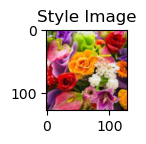

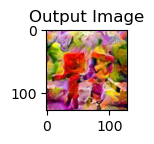

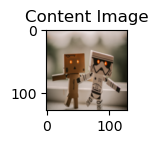

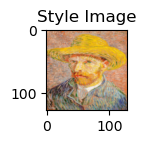

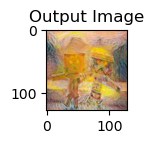

<Figure size 640x480 with 0 Axes>

In [9]:
for content_image_name in content_images:
    content_image_path = os.path.join(content_dir, content_image_name)
    content_image = load_image(content_image_path)
    
    plt.figure(figsize=(100, 5 * len(style_images)))
    
    for idx, style_image_name in enumerate(style_images, start=1):
        style_image_path = os.path.join(style_dir, style_image_name)
        style_image = load_image(style_image_path, get_image_size(content_image))
        output_image_name = f"{os.path.splitext(content_image_name)[0]}_{os.path.splitext(style_image_name)[0]}.jpg"
        output_image_path = os.path.join(output_dir, output_image_name)
        output_image = load_image(output_image_path)  # Load the output image
        
        # Calculate the subplot indices to ensure they are in rows
        row_index = (idx - 1) * 3
        
        # Display content image in the first column of the current row
        plt.subplot(len(style_images), 3, row_index + 1)
        imshow(content_image, title='Content Image')
        
        # Display style image in the second column of the current row
        plt.subplot(len(style_images), 3, row_index + 2)
        imshow(style_image, title='Style Image')
        
        # Display output image in the third column of the current row
        plt.subplot(len(style_images), 3, row_index + 3)
        imshow(output_image, title='Output Image')
    
    plt.tight_layout()
    plt.show()
